# Introduction

In [1]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize
import tensorflow as tf

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import fmin_l_bfgs_b

tf.compat.v1.disable_eager_execution()

In [2]:
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)

In [3]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [4]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

**load the content image**

In [5]:
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

In [6]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G

In [7]:
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]

In [8]:
style_path = 'input/StyleImages'
content_path = 'input/ContentImages'

In [9]:
# useful for getting number of files
style_files = glob(style_path + '/*.jp*g')
content_files = glob(content_path + '/*.jp*g')

In [10]:
c_img = np.random.choice(content_files)
s_img = np.random.choice(style_files)

In [11]:
content_img = load_img_and_preprocess(
  c_img,
  #(225, 300),
)

resize the style image
since we don't care too much about warping it

In [12]:

h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
    s_img,
  (h, w)
)


# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [13]:
# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)

58900480/58889256 [==============================] - 0s 0us/step


2021-12-08 11:27:18.735437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 11:27:18.841771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 11:27:18.842596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 11:27:18.844518: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
# create the content model
# we only want 1 output
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

2021-12-08 11:27:22.217683: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [15]:
# create the style model
# we want multiple outputs
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.2,0.4,0.3,0.5,0.2]

In [16]:
# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])

#tf.compat.v1.disable_eager_execution()
# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

In [17]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=9016.603515625
iter=1, loss=3102.004638671875
iter=2, loss=1772.581298828125
iter=3, loss=1303.20849609375
iter=4, loss=1072.5401611328125
iter=5, loss=922.4481811523438
iter=6, loss=814.1973266601562
iter=7, loss=737.809326171875
iter=8, loss=680.1279296875
iter=9, loss=633.092041015625
duration: 0:01:28.144531


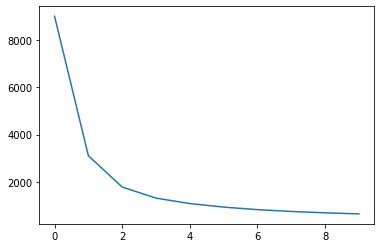

In [18]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)

# plot the content image

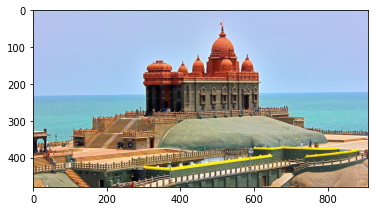

In [19]:
plt.imshow(image.load_img(c_img))

# plot the style image

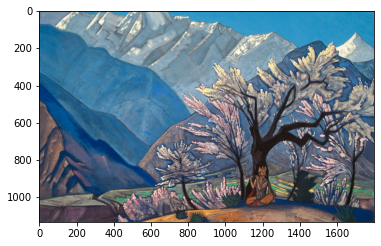

In [20]:
plt.imshow(image.load_img(s_img))

# plot the new image

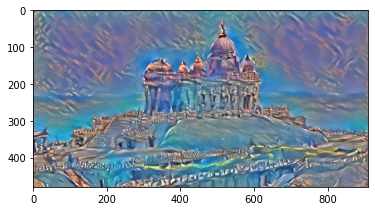

In [21]:
plt.imshow(scale_img(final_img))
plt.show()